# 1. Load the data we just saved

In [2]:
import pandas as pd
df=pd.read_csv('C:/Users/vecht499/Downloads/enron_data.csv',sep=';')

In [3]:
df=df[pd.notnull(df["text"])] ## if text is not available, drop it
df = df.reset_index(drop=True) ## reset index

In [4]:
len(df)
## 3 records dropped

4981

# 2. Modelling part

In [5]:
import scipy
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

## 2.1. Get features: TF-IDF

In [171]:
random.seed(0)
train, test = train_test_split(df, test_size = 0.2)

In [219]:
vectorizer = TfidfVectorizer( max_features = 40000,
                              ngram_range = ( 2, 2),
                              sublinear_tf = True )

tfidf = vectorizer.fit_transform(train["text"].tolist())
feature_names = vectorizer.get_feature_names() 

## 2.2. A bit of data exploration

In [252]:
def get_n_typical_words(indices,n):
    dense = tfidf.todense()
    
    x=list()
    for i in indices:
        x.append((dense[i]))
        
    dense1=np.vstack(x)
    
    email = np.mean(dense1, axis=0).tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len((email))), email)]    
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:n]:
        print('{0: <20} {1}'.format(phrase, score))

### 2.2.1. What are the typical spam phrases?

In [258]:
spam_indices=list()
for i,e in enumerate(train["spam_ind"].tolist()):
    if e==1:
        spam_indices.append(i)

In [259]:
get_n_typical_words(spam_indices,20)

click removed        0.00722288960591
font size            0.0068916305224
font family          0.0061476493687
advertisement solicitation 0.00581730754958
best regards         0.00507782695612
content disposition  0.00507115856738
windows professional 0.00467365219761
importance normal    0.00461014431947
nice day             0.00453426413563
adobe photoshop      0.00446721218985
please click         0.00428074391693
would like           0.00415251892292
gif content          0.00396763941358
soft tabs            0.00396719466726
phone mobile         0.00386203560804
office professional  0.00386146549455
boundary unsent      0.00375614278258
per dose             0.00364643046449
looking statements   0.00348996870852
attachment filename  0.00343239989127


### 2.2.1. What are the typical ham phrases?

In [256]:
ham_indices=list()
for i,e in enumerate(train["spam_ind"].tolist()):
    if e==0:
        ham_indices.append(i)

In [257]:
get_n_typical_words(ham_indices,20)

let know             0.0254608969654
original sent        0.0188256345271
please let           0.0160826486897
california scheduling 0.0146386035518
file portland        0.0146386035518
final schedules      0.0146386035518
iso final            0.0146386035518
log messages         0.0146386035518
messages parsing     0.0146386035518
parsing file         0.0146386035518
portland westdesk    0.0146386035518
schedules txt        0.0146386035518
scheduling iso       0.0146386035518
westdesk california  0.0146386035518
would like           0.0114947905761
please call          0.00894028087236
see attached         0.00878411977512
vince kaminski       0.00795133650871
next week            0.00737889750937
ect ect              0.00727318525552


## 2.3. Logistic regression

In [260]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

train_data_features=tfidf.toarray()
model = model.fit(train_data_features, train["spam_ind"])

In [261]:
test_data_features = vectorizer.transform(test["text"].tolist()).toarray()
probs = model.predict_proba(test_data_features)
result=[probs[x][1] for x in range(len(probs)) ]

### 10-fold cross validation to check mean accuracy (threshold standard 50%) : comparable!

In [266]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(model,train_data_features, train["spam_ind"], cv=10)

In [267]:
scores

array([ 0.89473684,  0.90726817,  0.88471178,  0.87468672,  0.88972431,
        0.88693467,  0.88190955,  0.88944724,  0.88944724,  0.88664987])

In [284]:
df_result_logit=pd.DataFrame({'ind':test["spam_ind"].tolist(),'score':result})
df_result_logit['prediction']=np.where(df_result_logit['score']>=0.5,1,0)
float(len(df_result_logit[df_result_logit['ind']==df_result_logit['prediction']]))/float(len(df_result_logit))

0.8906720160481444

### Model performance: ROC + AUC
Note: Estimating optimized accuracy is shown later in the Bonus part (done in R) 

In [262]:
from sklearn.metrics import roc_curve, auc
import numpy as np

y_test=np.asarray(test["spam_ind"].tolist())
y_score=np.asarray(result)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(result_df)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [263]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["micro"]

0.98334515628463759

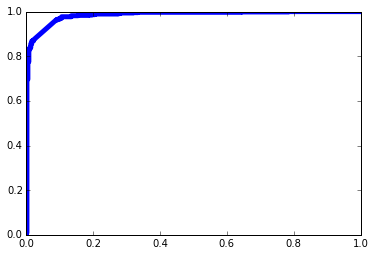

In [264]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=5)

## 2.4. Random forest

In [289]:
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(train_data_features, train["spam_ind"] )

In [290]:
test_data_features = vectorizer.transform(test["text"].tolist()).toarray()
#result = forest.predict(test_data_features)
result = forest.predict_proba(test_data_features)
result=[result[x][1] for x in range(len(result)) ]

In [291]:
df_result_rf=pd.DataFrame({'ind':test["spam_ind"].tolist(),'score':result})

In [292]:
y_test=np.asarray(test["spam_ind"].tolist())
y_score=np.asarray(result)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(result_df)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [293]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["micro"]

0.97783861671469741

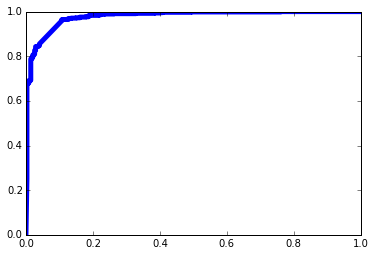

In [294]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=5)

# 3. Bonus: rpy2. Combine R and Python in the same notebook
## Compute optimal threshold for accuracy
In order to run it you need R kernel in the notebook, rpy2 and patience :-)

For more details: https://www.youtube.com/watch?v=T385txAYSt8&list=PL9rxFaZze-woP-1pmqy5Z2-A_zq0Zgl6d


In [295]:
%reload_ext rpy2.ipython

### Load some functions

In [302]:
%R library(plyr)
%R library(dplyr)
%R library(ggplot2)

array(['plyr', 'ggplot2', 'dplyr', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [297]:
%%R
getTestResults <- function(scores,  labels) {
df <- data.frame(labels = labels,
                   scores = scores,
                   dummy = 1)
num_customers <- nrow(df)
num_target <- sum(df$labels)
df %>% arrange(desc(scores)) %>%
    mutate(
      population = cumsum(dummy) / num_customers,
      target_population = cumsum(labels) / num_target,
      true_positives = cumsum(labels),
      false_positives = cumsum(dummy) - cumsum(labels),
      true_negatives = (num_customers - num_target - cumsum(dummy) +
                          cumsum(labels)),
      false_negatives = num_target - cumsum(labels)
    ) %>%
    select(
      scores,
      labels,
      population,
      target_population,
      true_positives,
      false_positives,
      true_negatives,
      false_negatives
    )
}


In [298]:
%R -i df_result_rf
%R -i df_result_logit

In [309]:
%R results_rf=getTestResults(df_result_rf$score,df_result_rf$ind)
%R results_rf$accuracy=(results_rf$true_positives+results_rf$true_negatives)/nrow(results_rf)
%R head(arrange(results_rf,desc(results_rf$accuracy)),1)
## threshold in score: >=0.60625 -> accuracy 94%

,scores,labels,population,target_population,true_positives,false_positives,true_negatives,false_negatives,accuracy
1,0.60625,1,0.664995,0.963077,626,37,310,24,0.938816


In [310]:
%R results_logit=getTestResults(df_result_logit$score,df_result_logit$ind)
%R results_logit$accuracy=(results_logit$true_positives+results_logit$true_negatives)/nrow(results_logit)
%R head(arrange(results_logit,desc(results_logit$accuracy)),1)
## threshold in score: >=0.635656 -> accuracy 95%

,scores,labels,population,target_population,true_positives,false_positives,true_negatives,false_negatives,accuracy
1,0.635656,1,0.674022,0.976923,635,37,310,15,0.947844


# Logistic regression wins!